In [1]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
import pickle
import pyprind
import re
from PIL import Image
from IPython.core.display import Image as img
import numpy as np
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud, ImageColorGenerator
import math
from prettytable import PrettyTable as PT
from collections import Counter

In [2]:
PATH_DATA = "V:/Programmazione/Amazon/"

In [3]:
df = pd.read_pickle("%sAmazonDataProject.pkl" % PATH_DATA)

# Preproccessing of the data

In [4]:
def percent(value,tot):
    return value/float(tot)*100

## Filtering of categories with less then 1000 reviews

In [5]:
categories = sorted(df.product_category.unique().tolist())
tempCategories = []
delCategories = []
N = 1000 #inferior limit
for c in categories:
    if(df[df.product_category==c].count()[0])>=N:
        tempCategories.append(c)
    else:
        delCategories.append(c)
tot = df.count()[0]
NKeep = df[df['product_category'].isin(tempCategories)].count()[0]
NDisc = tot-NKeep
print("CATEGORIES KEEPED (%d): %s" % (len(tempCategories),", ".join(tempCategories)))
print("WE ARE KEEPING %d/%d (%.2f%%) REVIEWS" % (NKeep,tot,percent(NKeep,tot)))
print("\nCATEGORIES REMOVED (%d): %s" % (len(delCategories),", ".join(delCategories)))
print("WE ARE DISCARDING %d/%d (%.2f%%) REVIEWS" % (NDisc,tot,percent(NDisc,tot)))

CATEGORIES KEEPED (20): Baby, Books, Camera, Digital_Ebook_Purchase, Digital_Music_Purchase, Digital_Video_Download, Electronics, Home, Mobile_Apps, Music, Musical Instruments, PC, Shoes, Sports, Toys, Video, Video DVD, Video Games, Watches, Wireless
WE ARE KEEPING 1702443/1705765 (99.81%) REVIEWS

CATEGORIES REMOVED (13): Apparel, Automotive, Beauty, Health & Personal Care, Home Entertainment, Home Improvement, Kitchen, Lawn and Garden, Luggage, Office Products, Personal_Care_Appliances, Pet Products, Software
WE ARE DISCARDING 3322/1705765 (0.19%) REVIEWS


In [6]:
categories = tempCategories
df = df[df['product_category'].isin(categories)] #keep only the reviews of products contained into "survival" categories

## Deletion of stopwords from reviews' bodies and headlines

In [7]:
"""
Given a the a string the function return the tokenization of the string, a list which contain all the words transformed in lowercase
"""
def tokenize(text):
    return [t.lower() for t in nltk.word_tokenize(text) if(not bool(re.search(r"[^A-Za-z]", t)))]

In [8]:
STOPWORDS = set(stopwords.words('english')).union([u'br'])

In [9]:
"""
Given a the list of strings the function return a list which contain all the words of the reviews which:
1. are not stopwords
2. contain only letters
"""
def deleteStopwords(text):
    return [t for t in text if (t not in STOPWORDS)]

In [10]:
try:
    df_rev = pd.read_pickle("%sReviews.pkl" % PATH_DATA)
    df_rev_stop = pd.read_pickle("%sReviews_without_stopwords.pkl" % PATH_DATA)
except IOError as I:
    df_rev = df.filter(["review_id","review_headline","review_body"], axis=1) #keep only the "interesting" columns
    df_rev["review_headline"] = df_rev["review_headline"].apply(func = tokenize) #apply the function deleteStopwords on headlines
    df_rev["review_body"] = df_rev["review_body"].apply(func = tokenize) #apply the function deleteStopwords on bodies
    df_rev.to_pickle("%sReviews.pkl" % PATH_DATA) #save the file
    df_rev_stop = df_rev.filter(["review_id","review_headline","review_body"], axis=1)
    df_rev_stop["review_headline"] = df_rev_stop["review_headline"].apply(func = deleteStopwords) #apply the function deleteStopwords on headlines
    df_rev_stop["review_body"] = df_rev_stop["review_body"].apply(func = deleteStopwords) #apply the function deleteStopwords on bodies
    df_rev_stop.to_pickle("%sReviews_without_stopwords.pkl" % PATH_DATA) #save the file

In [11]:
df_rev.head()

,review_headline,review_body
review_id,,
0,"[five, stars]","[the, best, album, ever]"
1,"[great, watch, from, casio]","[what, a, great, watch, both, watches, and, st..."
2,[fantastic],"[love, watching, all, the, episodes, of, dexte..."
3,"[five, stars]","[excellent, game]"
4,"[a, twist, on, tales]","[this, cute, quick, read, is, very, different,..."


In [12]:
df_rev_stop.head()

,review_headline,review_body
review_id,,
0,"[five, stars]","[best, album, ever]"
1,"[great, watch, casio]","[great, watch, watches, strap, great, quality,..."
2,[fantastic],"[love, watching, episodes, dexter, first, hear..."
3,"[five, stars]","[excellent, game]"
4,"[twist, tales]","[cute, quick, read, different, say, least, com..."


## Construction of "large" documents divided by categories/star ratings, body/headlines.

### Large document of categories' bodies

In [13]:
categories_reviews = dict()
all_reviews_without_stopwords = []
for c in categories:
    categories_reviews[c] = []
    for index,row in df[df.product_category==c].iterrows():
        categories_reviews[c]+= df_rev_stop.loc[index].review_body
    all_reviews_without_stopwords+=categories_reviews[c]

### Large document of categories' headlines

In [14]:
categories_reviews_headlines = dict()
for c in categories:
    categories_reviews_headlines[c] = []
    for index,row in df[df.product_category==c].iterrows():
        categories_reviews_headlines[c]+=df_rev_stop.loc[index].review_headline
    all_reviews_without_stopwords+=categories_reviews_headlines[c]

### Large document of star ratings' bodies

In [15]:
stars_body = dict()
for i in range(1,6):
    stars_body[i] = []
    for index,row in df[df.star_rating==i].iterrows():
        stars_body[i]+=df_rev_stop.loc[index].review_body

### Large document of star ratings' headlines

In [16]:
stars_head = dict()
for i in range(1,6):
    stars_head[i] = []
    for index,row in df[df.star_rating==i].iterrows():
        stars_head[i]+=df_rev_stop.loc[index].review_headline

# Stats on the text

### Number of reviews

In [17]:
t = PT(['Category', 'Number of reviews','% respect to the total'])
tot = float(df.count()[0])
for c in categories:
    count = df[df.product_category==c].count()[0]
    t.add_row([c,count,"%.2f%%" % percent(count,tot)])
t.align["Category"] = 'l'
print("Number of total reviews = %.0f" % tot)
print(t)

Number of total reviews = 1702443
+------------------------+-------------------+------------------------+
| Category               | Number of reviews | % respect to the total |
+------------------------+-------------------+------------------------+
| Baby                   |        4328       |         0.25%          |
| Books                  |       257793      |         15.14%         |
| Camera                 |        6427       |         0.38%          |
| Digital_Ebook_Purchase |       289111      |         16.98%         |
| Digital_Music_Purchase |       29263       |         1.72%          |
| Digital_Video_Download |       31420       |         1.85%          |
| Electronics            |        5846       |         0.34%          |
| Home                   |        2690       |         0.16%          |
| Mobile_Apps            |       218031      |         12.81%         |
| Music                  |       329854      |         19.38%         |
| Musical Instruments    |    

In [18]:
t = PT(['Stars', 'Number of reviews','% respect to the total'])
for i in range(1,6):
    count = df[df.star_rating==i].count()[0]
    t.add_row([i,count,"%.2f%%" % percent(count,tot)])
print("Number of total reviews = %.0f" % tot)
print(t)

Number of total reviews = 1702443
+-------+-------------------+------------------------+
| Stars | Number of reviews | % respect to the total |
+-------+-------------------+------------------------+
|   1   |       84270       |         4.95%          |
|   2   |       58966       |         3.46%          |
|   3   |       125421      |         7.37%          |
|   4   |       290995      |         17.09%         |
|   5   |      1142791      |         67.13%         |
+-------+-------------------+------------------------+


## Words Counts

### Categories' table

In [19]:
t = PT(['Category', 'Body','Body-stopwords','% del Body', 'Headline', 'Headline-stopwords','% del Headline'])
tot = 0
for c in categories:
    rows = df_rev[df_rev.index.isin(df[df['product_category']==c].index.tolist())]
    body_tot = rows.review_body.apply(len).sum()
    head_tot = rows.review_headline.apply(len).sum()
    body_stop = len(categories_reviews[c])
    head_stop = len(categories_reviews_headlines[c])
    t.add_row([c,
               body_tot,
               body_stop,
               "%.2f%%" % percent(body_tot-body_stop,body_tot),
               head_tot,
               head_stop,
               "%.2f%%" % percent(head_tot-head_stop,head_tot),
              ])
    tot+=body_tot+head_tot
    rows = None
print("Number of words (headline+body) of all reviews = %d, without stopwrods = %d, %% deleted = %.2f%%" % (tot,len(all_reviews_without_stopwords),percent(tot-len(all_reviews_without_stopwords),tot)))
t.align["Category"] = 'l'
print(t)

Number of words (headline+body) of all reviews = 116006962, without stopwrods = 58563321, % deleted = 49.52%
+------------------------+----------+----------------+------------+----------+--------------------+----------------+
| Category               |   Body   | Body-stopwords | % del Body | Headline | Headline-stopwords | % del Headline |
+------------------------+----------+----------------+------------+----------+--------------------+----------------+
| Baby                   |  213963  |     101372     |   52.62%   |  15536   |       10776        |     30.64%     |
| Books                  | 24020191 |    11604672    |   51.69%   | 1070932  |       705427       |     34.13%     |
| Camera                 |  425321  |     207691     |   51.17%   |  24989   |       17380        |     30.45%     |
| Digital_Ebook_Purchase | 12974492 |    6337738     |   51.15%   |  996553  |       683756       |     31.39%     |
| Digital_Music_Purchase | 1242343  |     618370     |   50.23%   |  957

### Rating stars' table

In [20]:
t = PT(['Stars', 'Body','Body-stopwords','% del Body', 'Headline', 'Headline-stopwords','% del Headline'])
for i in range(1,6):
    rows = df_rev[df_rev.index.isin(df[df['star_rating']==i].index.tolist())]
    body_tot = rows.review_body.apply(len).sum()
    head_tot = rows.review_headline.apply(len).sum()
    body_stop = len(stars_body[i])
    head_stop = len(stars_head[i])
    t.add_row(['*'*i,
               body_tot,
               body_stop,
               "%.2f%%" % percent(body_tot-body_stop,body_tot),
               head_tot,
               head_stop,
               "%.2f%%" % percent(head_tot-head_stop,head_tot),
              ])
    rows = None
print("Number of words (headline+body) of all reviews = %d, without stopwrods = %d, %% deleted = %.2f%%" % (tot,len(all_reviews_without_stopwords),percent(tot-len(all_reviews_without_stopwords),tot)))
print(t)

Number of words (headline+body) of all reviews = 116006962, without stopwrods = 58563321, % deleted = 49.52%
+-------+----------+----------------+------------+----------+--------------------+----------------+
| Stars |   Body   | Body-stopwords | % del Body | Headline | Headline-stopwords | % del Headline |
+-------+----------+----------------+------------+----------+--------------------+----------------+
|   *   | 6488934  |    3127289     |   51.81%   |  326437  |       207421       |     36.46%     |
|   **  | 5988584  |    2887129     |   51.79%   |  241294  |       148288       |     38.54%     |
|  ***  | 11422048 |    5525299     |   51.63%   |  510611  |       322061       |     36.93%     |
|  **** | 23176603 |    11442578    |   50.63%   | 1080321  |       744226       |     31.11%     |
| ***** | 62979109 |    31429055    |   50.10%   | 3793021  |      2729975       |     28.03%     |
+-------+----------+----------------+------------+----------+--------------------+---------

### Categories' graphs

In [ ]:
def plotFreq(list_words,subplot_column,title):
    fr = nltk.FreqDist(list_words)
    plt.rcParams["figure.figsize"] = (5, 8)
    plt.subplot(1, 2, subplot_column)
    plt.title(title, fontsize = 15)
    fr.plot(30)

In [ ]:
for c in categories:
    plotFreq(categories_reviews[c],1,"%s body" % c)
    plotFreq(categories_reviews_headlines[c],2,"%s headline" % c)
    plt.show()
    break

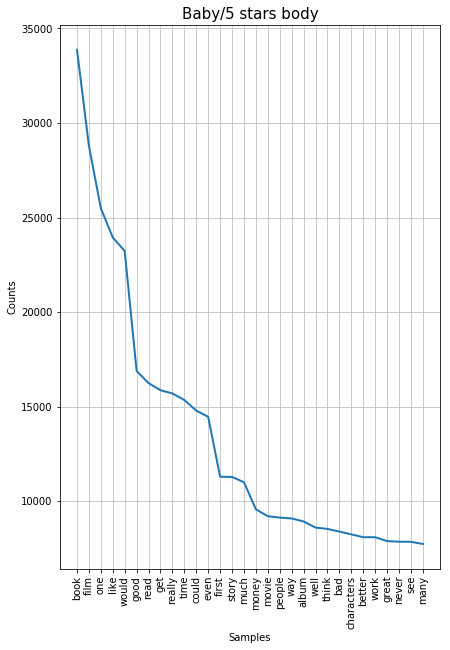

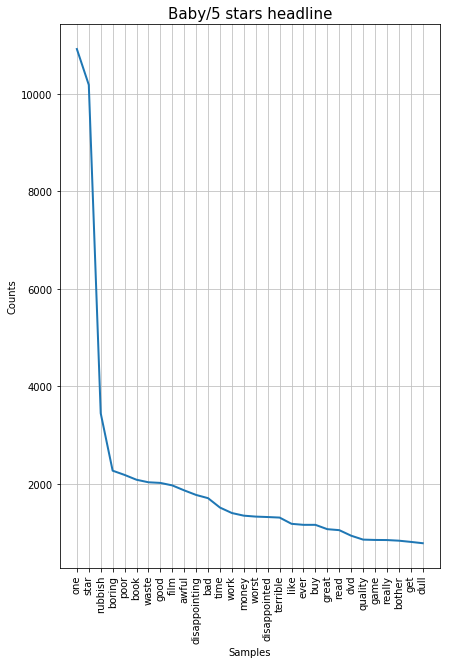

In [23]:
for i in range(1,6):
    plotFreq(stars_body[i],1,"%s/5 stars body" % i)
    plotFreq(stars_head[i],2,"%s/5 stars headline" % i)
    plt.show()
    break

### Lexical diversity

In [24]:
def lexical_diversity(text):
    return len(text)/len(set(text))

In [25]:
t = PT(['Category', 'Body', 'Headline'])
for c in categories:
    t.add_row([c,lexical_diversity(categories_reviews[c]),lexical_diversity(categories_reviews_headlines[c])])
t.align["Category"] = 'l'
print(t)

+------------------------+------+----------+
| Category               | Body | Headline |
+------------------------+------+----------+
| Baby                   |  14  |    6     |
| Books                  |  93  |    25    |
| Camera                 |  17  |    7     |
| Digital_Ebook_Purchase |  86  |    32    |
| Digital_Music_Purchase |  22  |    9     |
| Digital_Video_Download |  17  |    11    |
| Electronics            |  16  |    6     |
| Home                   |  7   |    4     |
| Mobile_Apps            |  64  |    25    |
| Music                  |  95  |    28    |
| Musical Instruments    |  11  |    4     |
| PC                     |  25  |    10    |
| Shoes                  |  8   |    4     |
| Sports                 |  9   |    4     |
| Toys                   |  24  |    12    |
| Video                  |  11  |    3     |
| Video DVD              | 105  |    33    |
| Video Games            |  12  |    4     |
| Watches                |  11  |    6     |
| Wireless

## Collocations

## Categories

### Bigrams (body+headline) with stopwords

In [ ]:
t = PT(['Category (body+headline)', '1st', '2nd', '3rd','4th'])
for c in categories:
    rows = df_rev[df_rev.index.isin(df[df.product_category==c].index.tolist())]
    finder = BigramCollocationFinder.from_words(df_rev.review_body.sum())
    finder.apply_freq_filter(3) ##ignoring all bigrams which occur less than three times in the corpus
    res = list(finder.nbest(bigram_measures.pmi, 4))
    res = [" ".join(r) for r in res]
    t.add_row([c,res[0],res[1],res[2],res[3]])
    rows = None
t.align["Category"] = 'l'
print(t)

### Bigrams (body+headline) without stopwords

In [ ]:
t = PT(['Category (body+headline)', '1st', '2nd', '3rd','4th'])
for c in categories:
    finder = BigramCollocationFinder.from_words(categories_reviews[c]+categories_reviews_headlines[c])
    finder.apply_freq_filter(3) ##ignoring all bigrams which occur less than three times in the corpus
    res = list(finder.nbest(bigram_measures.pmi, 4))
    res = [" ".join(r) for r in res]
    t.add_row([c,res[0],res[1],res[2],res[3]])
t.align["Category"] = 'l'
print(t)

### Trigrams (body+headline) with stopwords

In [ ]:
t = PT(['Category (body+headline)', '1st', '2nd', '3rd'])
for c in categories:
    rows = df_rev[df_rev.index.isin(df[df['product_category'].isin([c])].index.tolist())]
    finder3 = TrigramCollocationFinder.from_words(rows.review_body.tolist()+rows.review_headline.tolist())
    finder3.apply_freq_filter(3) ##ignoring all trigrams which occur less than three times in the corpus
    res = list(finder3.nbest(trigram_measures.pmi, 3))
    res = [" ".join(r) for r in res]
    t.add_row([c,res[0],res[1],res[2]])
    rows = None
t.align["Category"] = 'l'
print(t)

### Trigrams (body+headline) without stopwords

In [ ]:
t = PT(['Category (body+headline)', '1st', '2nd', '3rd'])
for c in categories:
    finder3 = TrigramCollocationFinder.from_words(categories_reviews[c]+categories_reviews_headlines[c])
    finder3.apply_freq_filter(3) ##ignoring all trigrams which occur less than three times in the corpus
    res = list(finder3.nbest(trigram_measures.pmi, 3))
    res = [" ".join(r) for r in res]
    t.add_row([c,res[0],res[1],res[2]])
t.align["Category"] = 'l'
print(t)

# Words

## Common words vs TF_IDF

### Functions

In [ ]:
def tfIdf(fdistList):
    N_DOCUMENTS = len(fdistList)
    print("Total number of documents = %d" % N_DOCUMENTS)
    vocab = set()
    print("I'm creating the dictionary")
    for fdist in fdistList.values():
        vocab = vocab.union(set(fdist.keys()))#all words presents in all the documents
    idf = dict()
    print("I'm calculating the IDF")
    for word in vocab:
        count = 0.0
        for fdist in fdistList.values():
            if(word in fdist):
                count+=1
        idf[word] = math.log(N_DOCUMENTS/count)
    listTfIdf = dict()
    print("I'm calculating the tf-idf")
    i = 0
    for title, fdist in fdistList.items():
        listTfIdf[title] = dict()
        n_token_document = float(sum(fdist.values()))
        for word in fdist:
            listTfIdf[title][word] = fdist[word] * idf[word] /  n_token_document
        i+=1
    print("I have finished")
    return listTfIdf

In [ ]:
#Function to draw the wordcloud
def make_word_cloud(dictWords, mask_path=None, background_color = "white", max_words = 2000, title = "", mux = 1, subplots_params = (1,1,1)):
    if(max_words>len(dictWords)):
        max_words = len(dictWords)
    topK = sorted(dictWords.iteritems(), key = lambda (k, v): (v, k), reverse = True)[:max_words]
    text =[] 
    for word, value in topK:
        text+=[word]*int(round(value*mux))
    text = " ".join(text)
    if(mask_path!=None):
        # read the mask image
        mask = np.array(Image.open(mask_path))
        wc = WordCloud(background_color = background_color, max_words = max_words,  mask = mask, stopwords = None, collocations = False, max_font_size = 120)
        
    else:
        wc = WordCloud(background_color = background_color, max_words = max_words, stopwords = None, collocations = False, max_font_size = 120)
    # generate word cloud
    wc.generate(text)
    if(mask_path!=None):
        wc.recolor(color_func=ImageColorGenerator(mask))
    # store to file
    plt.subplot(subplots_params[0], subplots_params[1], subplots_params[2])
    plt.rcParams["figure.figsize"] = (15, 10)
    plt.title(title, fontsize = 15)
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis("off")

### Calculations of most common words 

Draw wordlcloud taking into account all the categories (body+headline)

In [ ]:
freq = nltk.FreqDist(all_reviews_without_stopwords)
make_word_cloud({v:k for v,k in freq.most_common(300)}, max_words = 300, title = "Most common word taking into account all categories together", mask_path = "ImagesWordClouds/amazon.jpg")
plt.show()

### Calculation of most important words based on the TF-IDF for each category

In [ ]:
freq_dist_categories = dict()
for c in categories:
    freq_dist_categories[c] = nltk.FreqDist(categories_reviews[c]+categories_reviews_headlines[c])

In [ ]:
listTfIdf_categories = tfIdf(freq_dist_categories)

### Differences between Most common and TF-IDF words

Print the differences between them (body+headline)

In [ ]:
mux = len(all_reviews_without_stopwords) #This will multiply the tf-idf to make them bigger than 0., otherwise is not possible to create the text for the wordcloud.
n = 300
for c in categories:
    make_word_cloud({v:k for v,k in freq_dist_categories[c].most_common(n)}, max_words = n, title = "Most common words in %s" % c, mask_path = "ImagesWordClouds/%s.jpg" % c,subplots_params=(1,2,1))
    make_word_cloud(listTfIdf_categories[c], max_words = n, title = "TF-IDF words in %s" % c, mux = mux, mask_path = "ImagesWordClouds/%s.jpg" % c, subplots_params=(1,2,2))
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

## TF-IDF body vs TF-IDF headline

In [ ]:
freq_dist_categories_bodies = dict()
for c in categories:
    freq_dist_categories_bodies[c] = nltk.FreqDist(categories_reviews[c])

In [ ]:
listTfIdf_bodies = tfIdf(freq_dist_categories_bodies)

In [ ]:
freq_dist_categories_headlines = dict()
for c in categories:
    freq_dist_categories_headlines[c] = nltk.FreqDist(categories_reviews_headlines[c])

In [ ]:
listTfIdf_headlines = tfIdf(freq_dist_categories_headlines)

In [ ]:
mux = len(all_reviews_without_stopwords) #This will multiply the tf-idf to make them bigger than 0., otherwise is not possible to create the text for the wordcloud.
n = 300
for c in categories:
    make_word_cloud(listTfIdf_bodies[c], max_words = n, title = "TF-IDF body in %s" % c, mux = mux, mask_path = "ImagesWordClouds/%s.jpg" % c, subplots_params=(1,2,1))
    make_word_cloud(listTfIdf_headlines[c], max_words = n, title = "TF-IDF headlline in %s" % c, mux = mux, mask_path = "ImagesWordClouds/%s.jpg" % c, subplots_params=(1,2,2))
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

## Words based on the star_rating

We expect to find words which has a sentiment value based on the star rating. For example, for the reviews of 1 start, we expect to find: "bad, worst..". Moreover, we forcast to have better more interesting results using the most common words approach compare to the tf-idf.

### Looking at the reviews' body

In [ ]:
freq_dist_stars_body = dict()
for i in range(1,6):
    freq_dist_stars_body[i] = nltk.FreqDist(stars_body[i])

In [ ]:
listTfIdf_stars_body = tfIdf(freq_dist_stars_body)

In [ ]:
mux = len(all_reviews_without_stopwords) 
n = 200
for i in range(1,6):
    make_word_cloud(listTfIdf_stars_body[i], max_words = n, title = "TF-IDF body in %d /5 stars" % i, mux = mux, mask_path = "ImagesWordClouds/%dstars.jpg" % i)
    plt.show()

In [ ]:
n = 200
for i in range(1,6):
    make_word_cloud({v:k for v,k in freq_dist_stars_body[i].most_common(n)}, max_words = n, title = "Most common words body in %d /5 stars" % i, mask_path = "ImagesWordClouds/%dstars.jpg" % i)
    plt.show()

### Looking at the reviews' headline

In [ ]:
freq_dist_stars_head = dict()
for i in range(1,6):
    freq_dist_stars_head[i] = nltk.FreqDist(stars_head[i])

In [ ]:
listTfIdf_stars_head = tfIdf(freq_dist_stars_head)

In [ ]:
mux = len(all_reviews_without_stopwords) 
n = 200
for i in range(1,6):
    make_word_cloud(listTfIdf_stars_head[i], max_words = n, title = "TF-IDF headline in %d /5 stars" % i, mux = mux, mask_path = "ImagesWordClouds/%dstars.jpg" % i)
    plt.show()

In [ ]:
n = 200
for i in range(1,6):
    make_word_cloud({v:k for v,k in freq_dist_stars_head[i].most_common(n)}, max_words = n, title = "Most common words headline in %d /5 stars" % i, mask_path = "ImagesWordClouds/%dstars.jpg" % i)
    plt.show()

### Conclusions

It seems it is far better to look at the headline to catch the "sentiment" of the reviews.

# Sentiment analysis